In [1]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

at above we import all the libraries requaredaa

In [2]:
def data_labeling(img_files, txt_path):
    full_data = []
    count_cancer = 0
    img_coordinate = defaultdict(list)
    for i, filename in enumerate(sorted(os.listdir(img_files))):
        if filename.endswith(".pgm"):
            image_path = os.path.join(img_files, filename)
            text = txt_file[i].strip()

            pairing = {"Image": image_path, "Text": text}
            full_data.append(pairing)

    for pairing in full_data:
        txt_value = pairing['Text']
        img_value = pairing['Image']
        img = cv2.imread(img_value)
        txt_parts = txt_value.split()
        # print(f" {txt_value} {img_value}")
        # cordinate = {}
        
        if len(txt_parts) == 7 and img is not None:
            count_cancer += 1
            get_txt_data = txt_parts[4] + " - " + txt_parts[5] + " - " +txt_parts[6] + " - " +img_value[9:]
            # print(" x      y    R")
            # print(get_txt_data)
            
            x = int(txt_parts[4])
            y = 1024 - int(txt_parts[5])
            radius = int(txt_parts[6])
            # img_coordinate[img_value].append((x,y,radius))
            # getting the repeated cordinate
            
            
            
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cv2.circle(img_rgb, (x, y), radius, (0, 255, 0), 2)
            # Create a mask for the circular ROI
            mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
            cv2.circle(mask, (x, y), radius, 255, -1)  # Fill the circle with white
            # Extract the circular ROI using the mask
            roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
            # plt.imshow(img_rgb)
            # plt.show()
    # for img_path, coordinates in img_coordinate.items():
    #     print(f"Image: {img_path} Coordinates: {coordinates} ")
        
# reading the Image file 
images_path = "all-mias"

# reading the txt file 
txt_path = "Info.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()

data_labeling(images_path, txt_path)


In [3]:
print(count_cancer) 

NameError: name 'count_cancer' is not defined

In [4]:
def data_labeling(img_files, txt_path):
    full_data = []
    count_cancer = 0
    text_count = defaultdict(int)

    # Reading image file paths and corresponding text values
    for i, filename in enumerate(sorted(os.listdir(img_files))):
        if filename.endswith(".pgm"):
            image_path = os.path.join(img_files, filename)
            text = txt_file[i].strip()

            pairing = {"Image": image_path, "Text": text}
            full_data.append(pairing)

    # Iterate through the full_data, process each image and extract coordinates
    for pairing in full_data:
        txt_value = pairing['Text']
        img_value = pairing['Image']
        img = cv2.imread(img_value)
        txt_parts = txt_value.split()
        tokens = pairing['Text'].split()
        txt_key = tokens[0]
        text_count[txt_key] += 1
    coordinates_dict = defaultdict(list)
    
    for entry in full_data:
        tokens = entry['Text'].split()
        if len(tokens) > 3:
            txt_key = tokens[0]  # Extract text key
            if text_count[txt_key] > 1:  # Only consider repeated text keys
                coords = list(map(int, tokens[-3:]))  # Extract last three as coordinates
                coordinates_dict[txt_key].append(coords)
            # x = int(txt_parts[4])
            # y = 1024 - int(txt_parts[5])
            # radius = int(txt_parts[6])

    for key, coords in coordinates_dict.items():
        print(f"{key}: {coords}")

# Reading the image file paths
images_path = "all-mias"

# Reading the txt file
txt_path = "Info.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()

# Run the data labeling function
data_labeling(images_path, txt_path)


mdb005: [[477, 133, 30], [500, 168, 26]]
mdb132: [[252, 788, 52], [335, 766, 18]]
mdb144: [[233, 994, 29], [313, 540, 27]]
mdb223: [[523, 482, 29], [591, 529, 6]]
mdb226: [[287, 610, 7], [329, 550, 25], [531, 721, 8]]
mdb239: [[645, 755, 40], [567, 808, 25]]
mdb249: [[544, 508, 48], [575, 639, 64]]


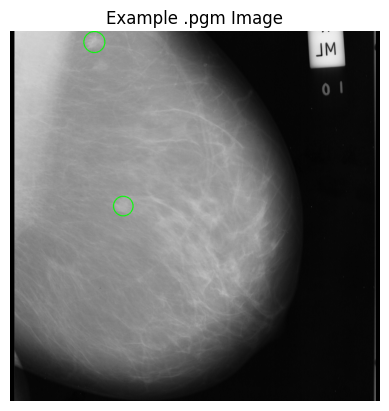

In [7]:
# reading the Image file 
# img_files = glob.glob("all-mias")
img_files_test = "all-mias/mdb144.pgm"
# print(f"found {len(img_files)} .pmg images")

# reading the txt file 
txt_path = "info.txt"
with open(txt_path, "r") as file:
    txt_file = file.readlines()

df = pd.read_csv('Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

    
img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)
# x, y, radius = 535, 425, 197
# custom_list = {}
mdb144 = [[233, 994, 29], [313, 540, 27]]
# if len(mdb144) > 1:
#     for x, sublist in enumerate(mdb144):
#         for y, cordinate in enumerate(sublist):
#             var_list = x, y
#             custom_list[var_list] = cordinate
            
#             # print(custom_list[var_list])
# for key, val in custom_list.items():
#     print(f" {key}, {val}")

sorted_mdb = sorted(mdb144, key=lambda item: item[-1])
for i in range(len(sorted_mdb)):
    x, y, r = sorted_mdb[i]
    y = 1024-y
    if len(sorted_mdb) > 1:
        x2, y2, r2 = sorted_mdb[0]
        y2 = 1024-y2




# y = 1024 - 540
# x = 313 
# radius = 27

# y2 = 1024 - 994
# x2 = 233
# radius2 = 29

cv2.circle(img_rgb_t, (x, y),r, (0, 255, 0), 2) 
cv2.circle(img_rgb_t, (x2,y2), r2, (0, 255, 0), 2) 
mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
cv2.circle(mask, (x, y), r, 255, -1)
roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

plt.imshow(img_rgb_t, cmap='gray')
plt.title("Example .pgm Image")
plt.axis('off')  # Hide axis ticks
plt.show()

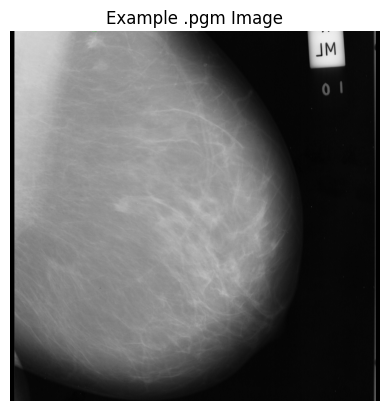

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read image file
img_files_test = "all-mias/mdb144.pgm"
img_t = cv2.imread(img_files_test, cv2.IMREAD_GRAYSCALE)
img_rgb_t = cv2.cvtColor(img_t, cv2.COLOR_GRAY2RGB)

# Example mdb144 data (x, y, radius)
mdb144 = [[233, 994, 29], [313, 540, 27]]

# Sort list by the y-coordinate (second element)
sorted_mdb = sorted(mdb144, key=lambda item: item[1])

# Process the first sublist
if len(sorted_mdb) >= 1:
    x, y, r = sorted_mdb[0]
    y_adj = y - 1024  # Adjust y-coordinate if necessary
    cv2.circle(img_rgb_t, (x, y_adj), r, (0, 255, 0), 2)
    # Overlay coordinate text
    cv2.putText(img_rgb_t, f"({x}, {y_adj})", (x, y_adj), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Process the second sublist if available
if len(sorted_mdb) >= 2:
    x2, y2, r2 = sorted_mdb[1]
    y2_adj = y2 - 1024  # Adjust y-coordinate if necessary
    cv2.circle(img_rgb_t, (x2, y2_adj), r2, (0, 255, 0), 2)
    # Overlay coordinate text
    cv2.putText(img_rgb_t, f"({x2}, {y2_adj})", (x2, y2_adj), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Create a mask using the first circle's parameters (if needed)
mask = np.zeros(img_rgb_t.shape[:2], dtype=np.uint8)
cv2.circle(mask, (x, y - 1024), r, 255, -1)
roi = cv2.bitwise_and(img_rgb_t, img_rgb_t, mask=mask)

# Display the result
plt.imshow(img_rgb_t)
plt.title("Example .pgm Image")
plt.axis('off')  # Hide axis ticks
plt.show()
